In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor

import warnings 
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("nyc_taxi_trip_duration.csv")

In [3]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [4]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [5]:
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day'] = df['pickup_datetime'].dt.dayofweek
df['dropoff_hour'] = df['dropoff_datetime'].dt.hour
df['dropoff_day'] = df['dropoff_datetime'].dt.dayofweek
df['pickup_month']=df['pickup_datetime'].dt.month
df['dropoff_month']=df['dropoff_datetime'].dt.month
df['pickup_location'] = df[['pickup_latitude', 'pickup_longitude']].apply(tuple, axis=1)
df['dropoff_location'] = df[['dropoff_latitude', 'dropoff_longitude']].apply(tuple, axis=1)

In [6]:
df_y=np.log1p(df['trip_duration'])

In [7]:
df['store_and_fwd_flag']=df['store_and_fwd_flag'].apply(lambda store_and_fwd_flag:1 if store_and_fwd_flag=='Y' else 0)

In [8]:
from haversine import haversine

In [9]:
df['distance_km'] = df.apply(lambda df: haversine(df['pickup_location'], df['dropoff_location']), axis=1)

In [10]:
df['vendor_id']=df['vendor_id']-1

In [11]:
df.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
pickup_hour                    int64
pickup_day                     int64
dropoff_hour                   int64
dropoff_day                    int64
pickup_month                   int64
dropoff_month                  int64
pickup_location               object
dropoff_location              object
distance_km                  float64
dtype: object

In [12]:
df = df.drop(['id','pickup_datetime','dropoff_datetime','store_and_fwd_flag','trip_duration','pickup_location','dropoff_location'], axis=1)

In [13]:
from math import sqrt

In [14]:
from sklearn.metrics import mean_squared_error

In [15]:
def cv_score(ml_model,rstate=12,cols=df.columns):
    i=1
    cv_scores=[]
    df1=df.copy()
    df1=df[cols]
    
    kf=KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index].values,df1.loc[test_index].values
        ytr,yvl = df_y[train_index].values,df_y[test_index].values
        
        model=ml_model
        model.fit(xtr,ytr)
        train_val = model.predict(xtr)
        pred_val = model.predict(xvl)
        rmse_score_train = sqrt(mean_squared_error(ytr,train_val))
        rmse_score = sqrt(mean_squared_error(yvl,pred_val))
        suffix = ""
        msg = ""
        msg += "Train RMSE: {:.5f}".format(rmse_score_train)
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        
        cv_scores.append(rmse_score)
        i+=1
    return cv_scores    

In [16]:
from sklearn.ensemble import RandomForestRegressor

In [17]:
rf_params = {'random_state':0, 'n_estimators':20, 'max_depth':11,'n_jobs':-1, 'min_samples_split':43}
rf_scores = cv_score(RandomForestRegressor(**rf_params))


1 of kfold 5
Train RMSE: 0.41956Valid RMSE: 0.42859

2 of kfold 5
Train RMSE: 0.41844Valid RMSE: 0.43250

3 of kfold 5
Train RMSE: 0.41774Valid RMSE: 0.43665

4 of kfold 5
Train RMSE: 0.41894Valid RMSE: 0.43122

5 of kfold 5
Train RMSE: 0.41891Valid RMSE: 0.43199


In [18]:
import xgboost as xgb

In [19]:
xtrain, xtest, ytrain, ytest = train_test_split(df,df_y,test_size=1/3,random_state=0)

In [20]:
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dvalid = xgb.DMatrix(xtest, label=ytest)

watchlist = [(dtrain,'train'),(dvalid,'valid')]

In [21]:
xgb_params = {}
xgb_params["objective"] = "reg:linear"
xgb_params["eval_metric"] = "rmse"
xgb_params["eta"] = 0.05
xgb_params["min_child_weight"] = 10
xgb_params["subsample"] = 0.9
xgb_params["colsample_bytree"] = 0.7
xgb_params["max_depth"] = 5
xgb_params["silent"] = 1
xgb_params["seed"] = 2019
xgb_params["nthread"] = -1
xgb_params["lambda"] = 2

xgb_model = xgb.train(xgb_params, dtrain, 10000, watchlist, early_stopping_rounds=50,maximize=False, verbose_eval=20)
print('Modelling RMSE %.5f' % xgb_model.best_score)

[0]	train-rmse:5.72448	valid-rmse:5.72162
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[20]	train-rmse:2.10261	valid-rmse:2.10134
[40]	train-rmse:0.86874	valid-rmse:0.86948
[60]	train-rmse:0.520427	valid-rmse:0.523417
[80]	train-rmse:0.447218	valid-rmse:0.451352
[100]	train-rmse:0.428905	valid-rmse:0.433545
[120]	train-rmse:0.421354	valid-rmse:0.426417
[140]	train-rmse:0.415947	valid-rmse:0.421266
[160]	train-rmse:0.411785	valid-rmse:0.417518
[180]	train-rmse:0.4085	valid-rmse:0.41469
[200]	train-rmse:0.404198	valid-rmse:0.410653
[220]	train-rmse:0.402036	valid-rmse:0.408748
[240]	train-rmse:0.398699	valid-rmse:0.405708
[260]	train-rmse:0.396796	valid-rmse:0.404159
[280]	train-rmse:0.394708	valid-rmse:0.402237
[300]	train-rmse:0.392547	valid-rmse:0.400399
[320]	train-rmse:0.390423	valid-rmse:0.398468
[340]	train-rmse:0.389343	valid-rmse:0.39768
[360]	train-rmse:0.387652	valid-rmse:0.3963

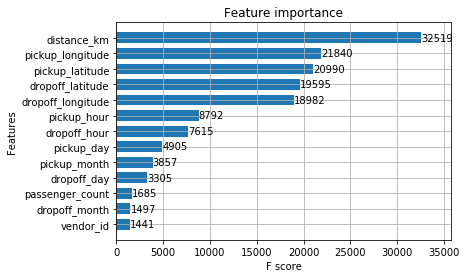

In [27]:
xgb.plot_importance(xgb_model, height=0.7)

In [28]:
xgb_params['num_round']=xgb_model.best_iteration
xgb_model_final = xgb.XGBRegressor()
xgb_score = cv_score(xgb_model_final)


1 of kfold 5
Train RMSE: 0.43492Valid RMSE: 0.43218

2 of kfold 5
Train RMSE: 0.43439Valid RMSE: 0.43397

3 of kfold 5
Train RMSE: 0.43511Valid RMSE: 0.44201

4 of kfold 5
Train RMSE: 0.43435Valid RMSE: 0.43549

5 of kfold 5
Train RMSE: 0.43566Valid RMSE: 0.43660


In [33]:
def cv_score_avg(ml_model_1, ml_model_2, w1=0.5, w2=0.5,rstate=12,cols=df.columns):
    i=1
    cv_scores=[]
    df1=df.copy()
    df1=df[cols]
    
    kf=KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index],df1.loc[test_index]
        ytr,yvl = df_y[train_index],df_y[test_index]
        
        model=ml_model_1
        ml_model_1.fit(xtr,ytr)
        pred_val_1 = ml_model_1.predict(xvl)
        
        model = ml_model_2
        ml_model_2.fit(xtr,ytr)
        pred_val_2 = ml_model_2.predict(xvl)
        
        final_pred = (pred_val_1*w1 + pred_val_2*w2)
        
        rmse_score = sqrt(mean_squared_error(yvl,final_pred))
        
        suffix = ""
        msg = ""
        
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        
        cv_scores.append(rmse_score)
        i+=1
    return cv_scores    

In [34]:
avg_scores = cv_score_avg(xgb_model_final, RandomForestRegressor(**rf_params),w1=0.4,w2=0.6)


1 of kfold 5
Valid RMSE: 0.42561

2 of kfold 5
Valid RMSE: 0.42856

3 of kfold 5
Valid RMSE: 0.43404

4 of kfold 5
Valid RMSE: 0.42821

5 of kfold 5
Valid RMSE: 0.42924


In [36]:
xgb_model = xgb.XGBRegressor(**xgb_params)
rf_model = RandomForestRegressor(**rf_params)

In [38]:
from mlxtend.regressor import StackingCVRegressor

stacked_model = StackingCVRegressor(
    regressors=[xgb_model, rf_model],
    meta_regressor = Ridge())

In [39]:
stacking_scores = cv_score(stacked_model)


1 of kfold 5
Train RMSE: 0.40991Valid RMSE: 0.40832

2 of kfold 5
Train RMSE: 0.41144Valid RMSE: 0.41306

3 of kfold 5
Train RMSE: 0.40602Valid RMSE: 0.41210

4 of kfold 5
Train RMSE: 0.40619Valid RMSE: 0.40704

5 of kfold 5
Train RMSE: 0.40897Valid RMSE: 0.41132


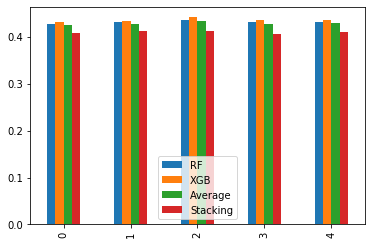

In [41]:
results_df=pd.DataFrame({'RF':rf_scores,'XGB':xgb_score,'Average':avg_scores,'Stacking':stacking_scores})
results_df.plot(y=["RF","XGB","Average","Stacking"],kind="bar")